In [5]:
!git clone https://github.com/neuroailab/lr-identify
%cd lr-identify

fatal: destination path 'lr-identify' already exists and is not an empty directory.
/content/lr-identify


In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [7]:
!bash get_dataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  511M  100  511M    0     0  52.0M      0  0:00:09  0:00:09 --:--:-- 56.0M


In [8]:
data = pickle.load(open('dataset.pkl', 'rb'), encoding='latin1')

In [9]:
from cross_validation import get_possible_inds

def filter_inds(learning_rule,
              architectures=['resnet18'],
              tasks=['imagenet'],
              dataset_seeds=[None],
              model_seeds=[None],
              batch_sizes=[256],
              layer_names=['conv0']):
  
  '''Helper function to subselect the data by, defaults to the first layer of 
  ResNet18 trained on ImageNet with a batch size of 256 
  and non-deterministic dataset randomization seed and model seed.'''

  if not isinstance(architectures, list):
      architectures = [architectures]
  if not isinstance(tasks, list):
      tasks = [tasks]
  if not isinstance(dataset_seeds, list):
      dataset_seeds = [dataset_seeds]
  if not isinstance(model_seeds, list):
      model_seeds = [model_seeds]
  if not isinstance(batch_sizes, list):
      batch_sizes = [batch_sizes]
  if not isinstance(layer_names, list):
      layer_names = [layer_names]

  filter = lambda x: (x['learning_rule'] == learning_rule) \
                   and (x['architecture'] in architectures) \
                   and (x['task'] in tasks) \
                   and (x['dataset_seed'] in dataset_seeds) \
                   and (x['model_seed'] in model_seeds) \
                   and (x['batch_size'] in batch_sizes) \
                   and (x['layer_name'] in layer_names)

  inds = get_possible_inds(metadata=data['meta'], filter=filter)
  return np.squeeze(inds)

In [10]:
!bash get_saved_results.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 82.6M  100 82.6M    0     0  29.4M      0  0:00:02  0:00:02 --:--:-- 29.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29574  100 29574    0     0  97603      0 --:--:-- --:--:-- --:--:-- 97603
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34261  100 34261    0     0   110k      0 --:--:-- --:--:-- --:--:--  111k


In [11]:
randomforest_results = pickle.load(open('saved_classifier_results/randomforest_allobs_results.pkl', 'rb'), encoding='latin1')

In [12]:
learning_rules = ['adam', 'sgdm', 'information', 'feedback']
task_filter = ['imagenet']
cls_filter = lambda x: (x['learning_rule'] in learning_rules) and (x['task'] in task_filter)

In [13]:
from cross_validation import get_possible_inds

cls_filter_first_lr = lambda x: (x['learning_rule'] == learning_rules[0]) and (x['task'] in task_filter)
cls_filter_first_lr_indices = get_possible_inds(data['meta'], cls_filter_first_lr)
num_total_per_class = len(cls_filter_first_lr_indices)
num_total_examples =  num_total_per_class * len(learning_rules)
# sanity check for category balanced data
assert(num_total_examples == len(get_possible_inds(data['meta'], cls_filter)))
# now we compute num per class train and test
train_frac = 0.75
num_per_class_train = (int)(np.ceil(train_frac*num_total_per_class))
num_per_class_test = num_total_per_class - num_per_class_train

In [14]:
from fit_pipeline import PipelineClassifier
from functools import partial

classifier_type = partial(PipelineClassifier, estimators=[('cls', 'randomforest')])
cv_param_grid = {'cls__max_features': ['sqrt', 'log2'], 'cls__n_estimators': [20, 50]}

In [ ]:
# activation 'act'

from fit_pipeline import ObsClassifier

cls_out = ObsClassifier(
                classifier_type=classifier_type, # 'randomforest' in this case
                num_splits=10, # number of train/test splits
                num_per_class_train=num_per_class_train, # how many examples per category to train on
                num_per_class_test=num_per_class_test, # how many examples per category to test on
                train_filter=cls_filter, # the subset of data we want to train on
                test_filter=cls_filter, # the subset of data we want to test on
                data=data, # the raw data
                cls_dataset_transform_kwargs={'obs_measure': 'act', 'num_dims': 2}, # train on activations observable measure, flattening trajectories
                cv_param_grid=cv_param_grid, # cross validation search space
                verbose=True)

Will be running cross val and returning results.
Score: 0.886734693877551. Num train examples: 3916. Num val examples: 980
Score: 0.9397344228804902. Num train examples: 3917. Num val examples: 979
model0_cls__max_featuressqrtcls__n_estimators20 failed to train
model0_cls__max_featuressqrtcls__n_estimators20 failed to train
model0_cls__max_featuressqrtcls__n_estimators20 failed to train
Score: 0.8959183673469387. Num train examples: 3916. Num val examples: 980
Score: 0.9448416751787538. Num train examples: 3917. Num val examples: 979
Score: 0.9642492339121552. Num train examples: 3917. Num val examples: 979


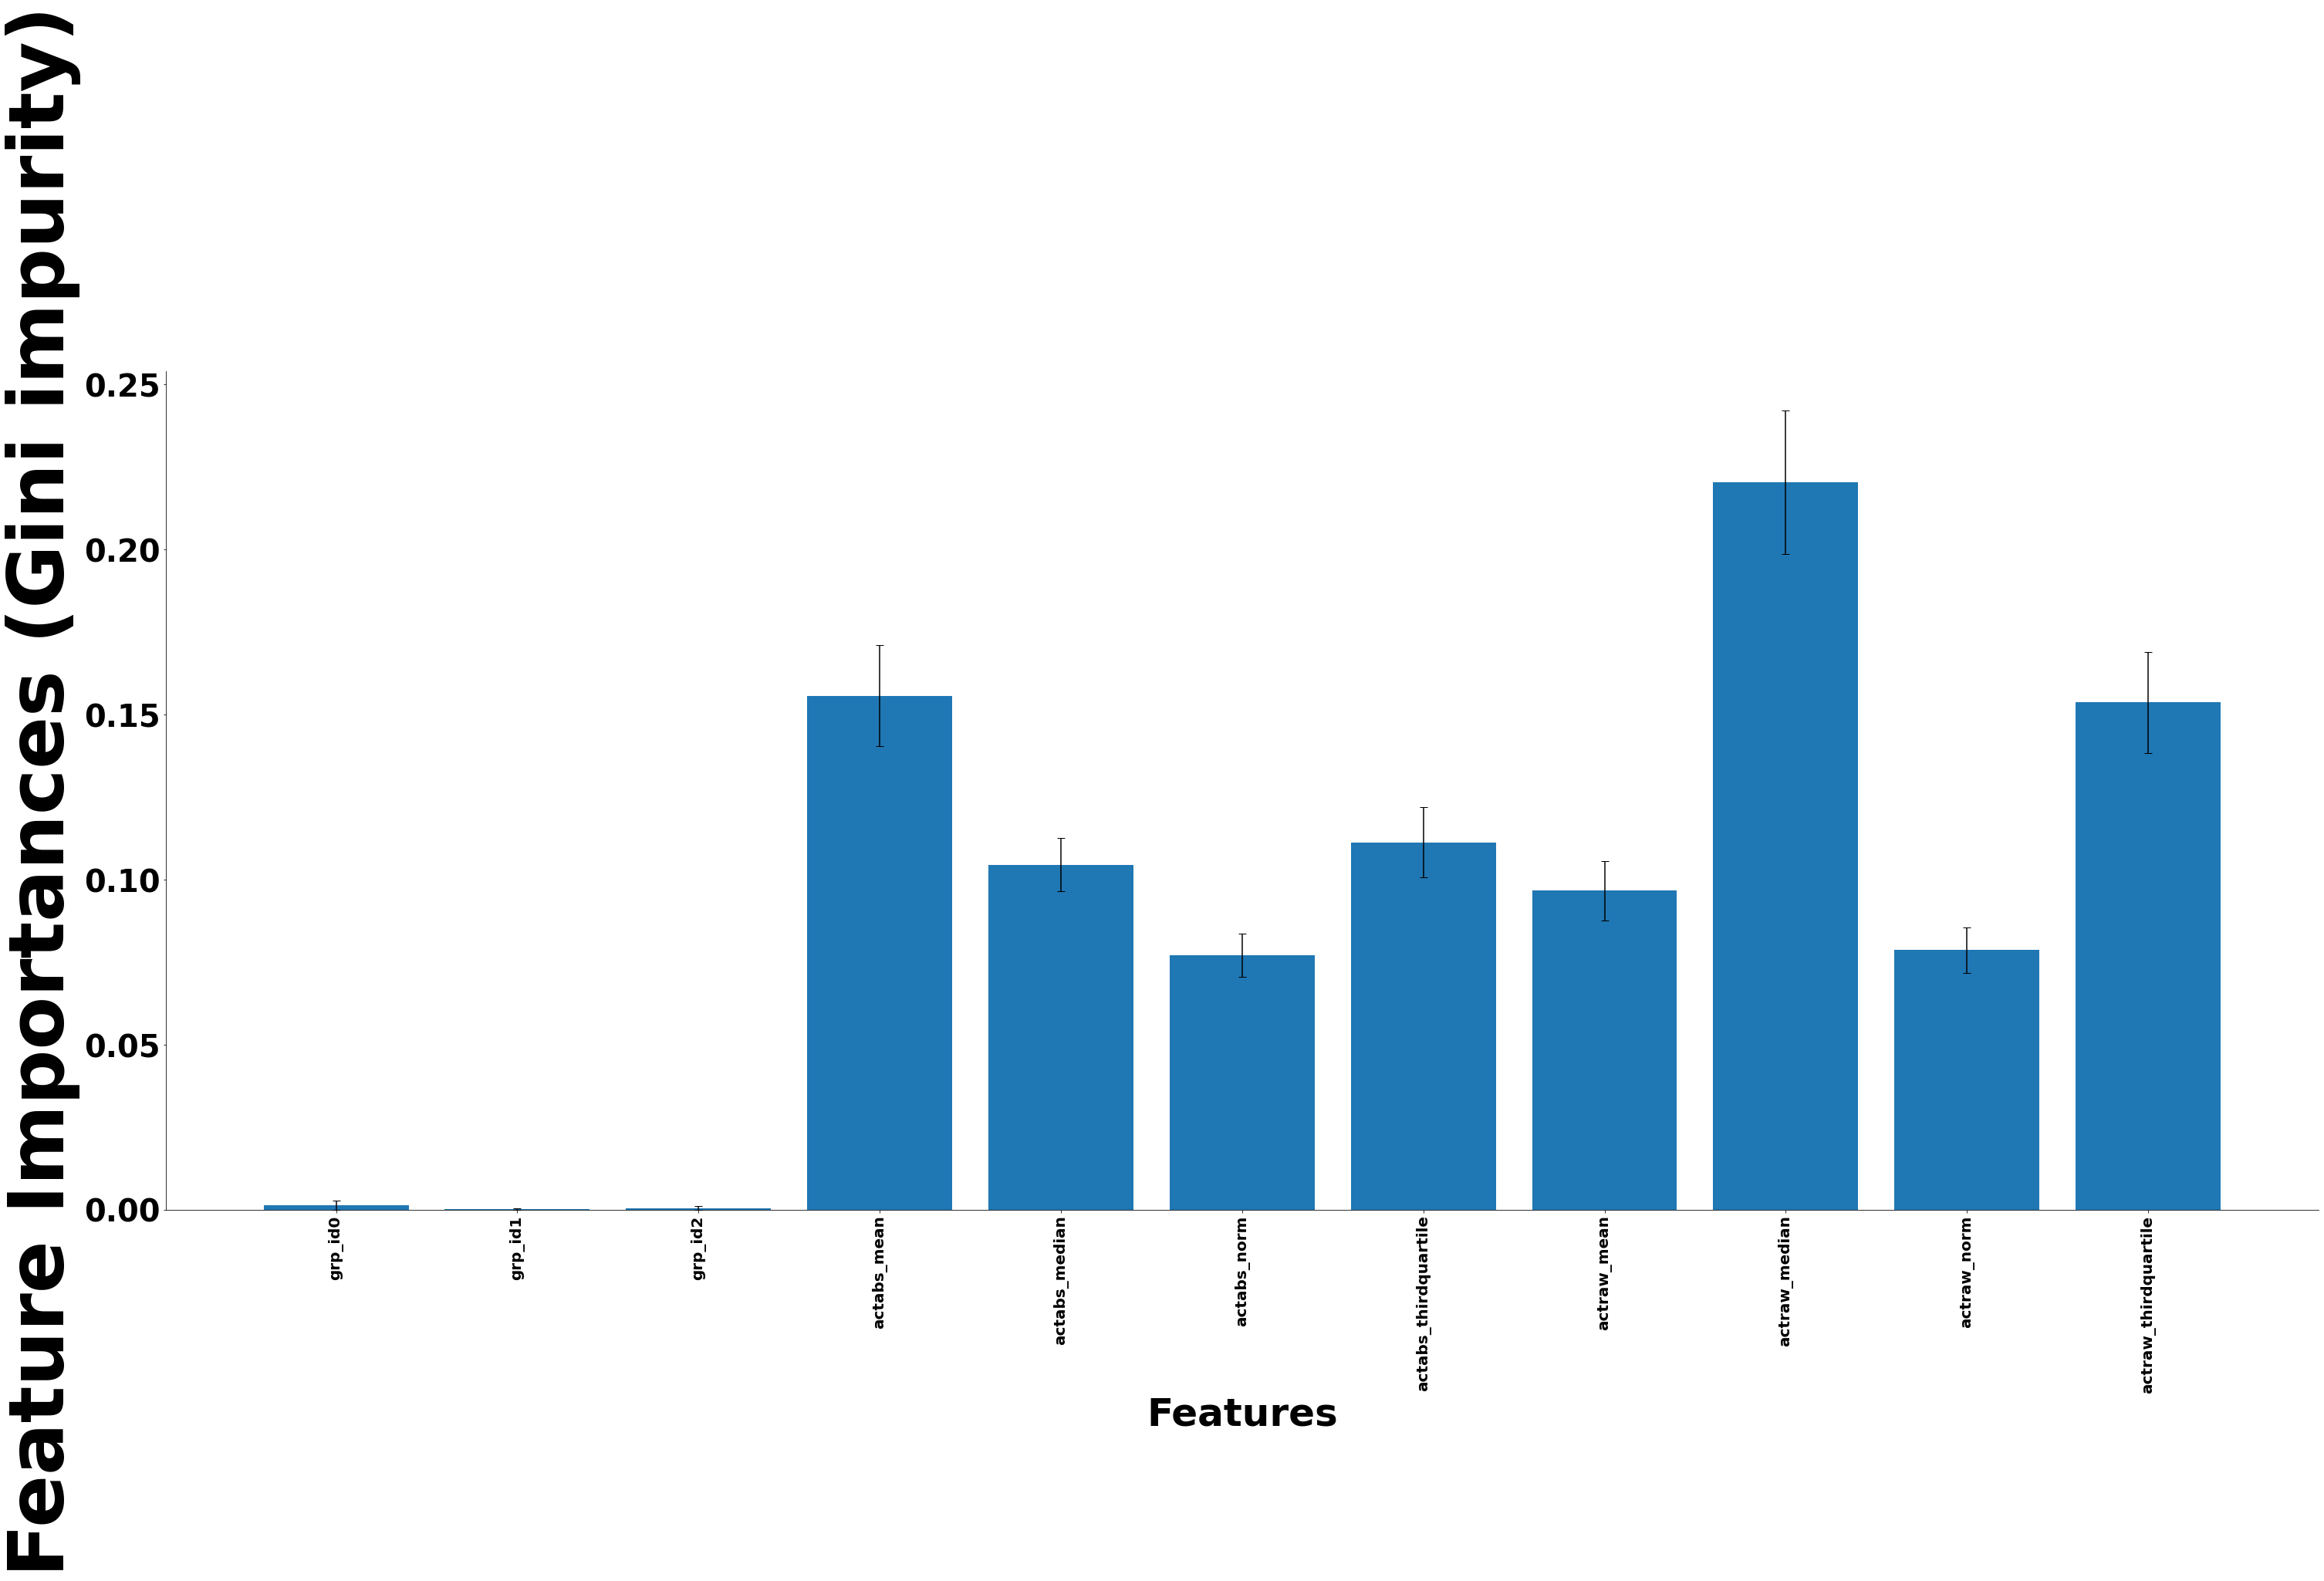

In [15]:
#act plot

from scipy.stats import sem

fig = plt.figure(figsize=(50, 20))

trajectory_len = data['X'].shape[1]
observable_trajectory_names = list(cls_out.results['feature_names'])
# observable_trajectory_names = list(cls_out.results['feature_names'][:3]) \
#                              + list(np.repeat(cls_out.results['feature_names'][3:], trajectory_len))
x = np.arange(len(observable_trajectory_names))
feat_importances = np.row_stack(cls_out.results['feature_importances_by_split'])

feat_importances_actMean = np.mean(feat_importances, axis=0)
feat_importances_actMean_3 = feat_importances_actMean[:3]
feat_importances_actMean_real = feat_importances_actMean[3:]
actMean_split = np.split(feat_importances_actMean_real,8)
feat_importances_actMean_sum = np.zeros(11,)
feat_importances_actMean_sum[:3] = feat_importances_actMean_3
feat_importances_actMean_sum[3:] = np.sum(actMean_split,axis=1)

feat_importances_actSem = sem(feat_importances, axis=0)
feat_importances_actSem_3 = feat_importances_actSem[:3]
feat_importances_actSem_real = feat_importances_actSem[3:]
actSem_split = np.split(feat_importances_actSem_real,8)
feat_importances_actSem_sum = np.zeros(11,)
feat_importances_actSem_sum[:3] = feat_importances_actMean_3
feat_importances_actSem_sum[3:] = np.sum(actSem_split,axis=1)

plt.bar(x, 
        feat_importances_actMean_sum,
        yerr = feat_importances_actSem_sum,
        capsize=5)
plt.xticks(x, observable_trajectory_names, rotation=90, 
           fontsize=20, fontweight='bold')
plt.yticks(fontsize=40, fontweight='bold')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Features', fontsize=50, fontweight='bold')
plt.ylabel('Feature Importances (Gini impurity)', fontsize=100, fontweight='bold')
plt.show()

In [15]:
# Weight 

from fit_pipeline import ObsClassifier

cls_out = ObsClassifier(
                classifier_type=classifier_type, # 'randomforest' in this case
                num_splits=10, # number of train/test splits
                num_per_class_train=num_per_class_train, # how many examples per category to train on
                num_per_class_test=num_per_class_test, # how many examples per category to test on
                train_filter=cls_filter, # the subset of data we want to train on
                test_filter=cls_filter, # the subset of data we want to test on
                data=data, # the raw data
                cls_dataset_transform_kwargs={'obs_measure': 'weight', 'num_dims': 2}, # train on activations observable measure, flattening trajectories
                cv_param_grid=cv_param_grid, # cross validation search space
                verbose=True)

Will be running cross val and returning results.
Score: 0.9714285714285714. Num train examples: 3916. Num val examples: 980
Score: 0.9979570990806946. Num train examples: 3917. Num val examples: 979
Score: 0.9918283963227783. Num train examples: 3917. Num val examples: 979
Score: 0.9867211440245148. Num train examples: 3917. Num val examples: 979
Score: 0.9775280898876404. Num train examples: 3917. Num val examples: 979
Score: 0.976530612244898. Num train examples: 3916. Num val examples: 980
Score: 0.9989785495403473. Num train examples: 3917. Num val examples: 979
Score: 0.9938712972420838. Num train examples: 3917. Num val examples: 979
Score: 0.9867211440245148. Num train examples: 3917. Num val examples: 979
Score: 0.9765066394279878. Num train examples: 3917. Num val examples: 979
Score: 0.976530612244898. Num train examples: 3916. Num val examples: 980
Score: 0.9969356486210419. Num train examples: 3917. Num val examples: 979
Score: 0.9918283963227783. Num train examples: 3917. 

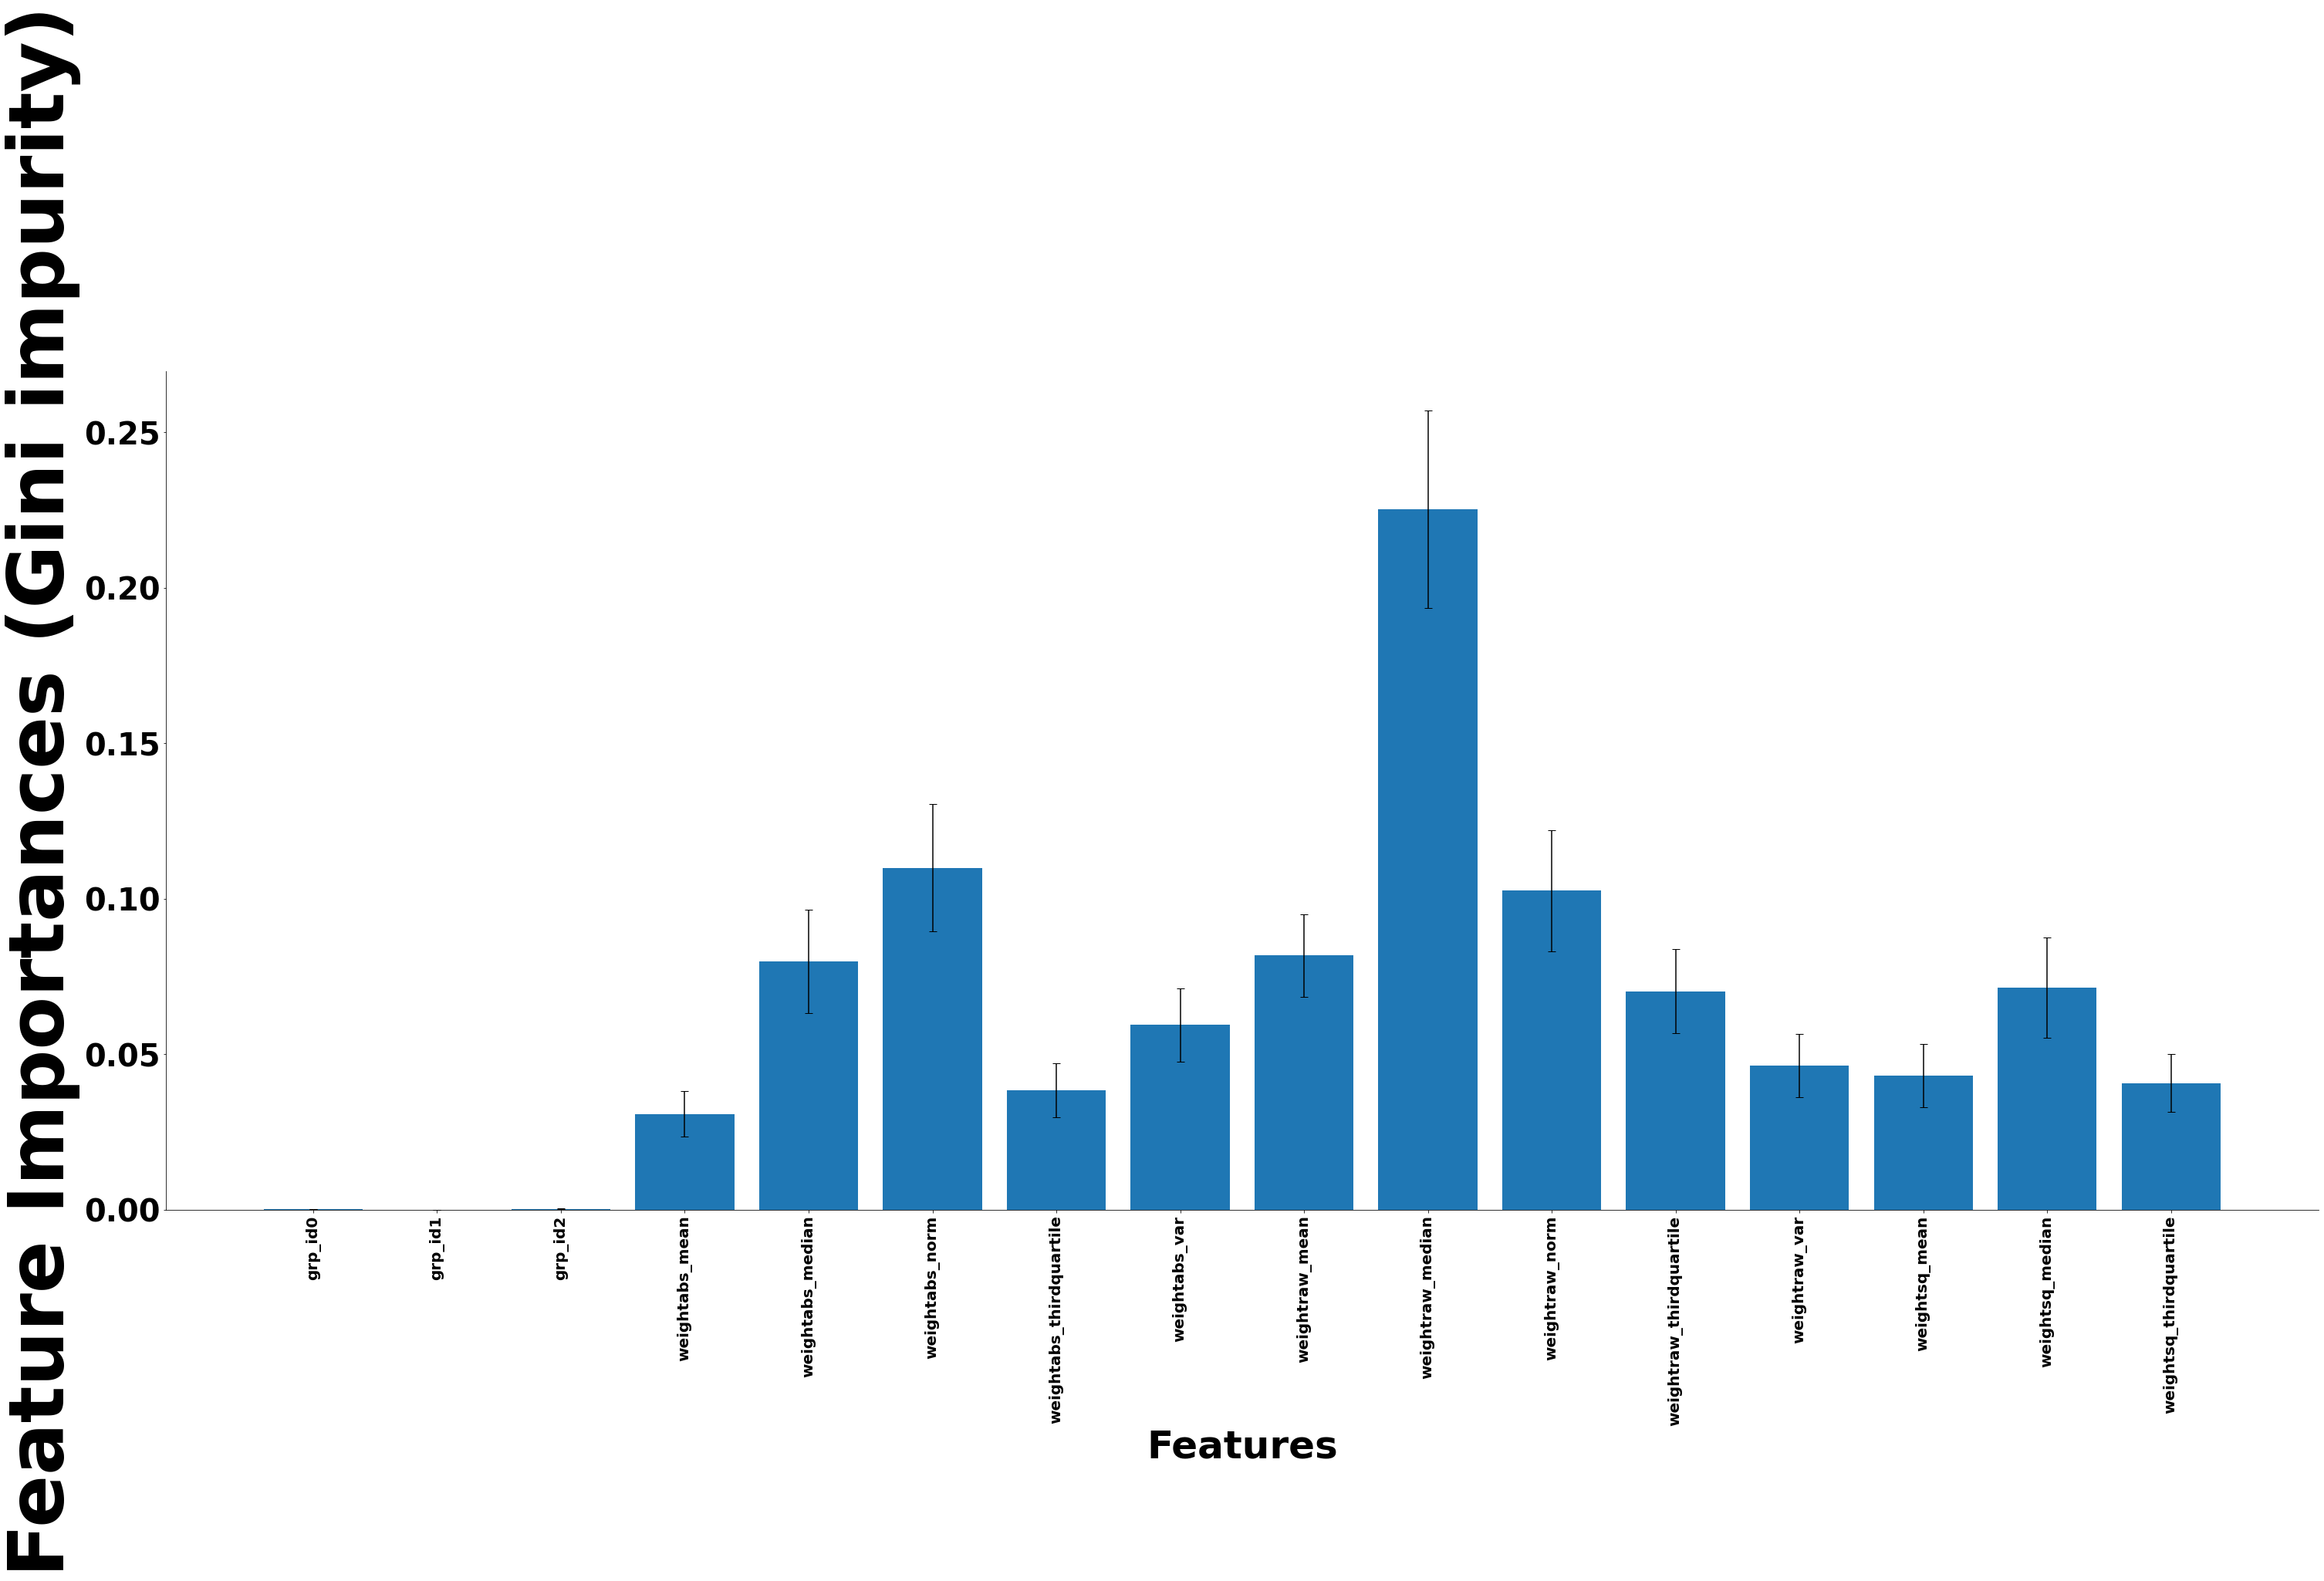

In [16]:
#Weight plot

from scipy.stats import sem

fig = plt.figure(figsize=(50, 20))

trajectory_len = data['X'].shape[1]
observable_trajectory_names = list(cls_out.results['feature_names'])
# observable_trajectory_names = list(cls_out.results['feature_names'][:3]) \
#                              + list(np.repeat(cls_out.results['feature_names'][3:], trajectory_len))
x = np.arange(len(observable_trajectory_names))
feat_importances = np.row_stack(cls_out.results['feature_importances_by_split'])

feat_importances_weightMean = np.mean(feat_importances, axis=0)
feat_importances_weightMean_3 = feat_importances_weightMean[:3]
feat_importances_weightMean_real = feat_importances_weightMean[3:]
weightMean_split = np.split(feat_importances_weightMean_real,13)
feat_importances_weightMean_sum = np.zeros(16,)
feat_importances_weightMean_sum[:3] = feat_importances_weightMean_3
feat_importances_weightMean_sum[3:] = np.sum(weightMean_split,axis=1)

feat_importances_weightSem = sem(feat_importances, axis=0)
feat_importances_weightSem_3 = feat_importances_weightSem[:3]
feat_importances_weightSem_real = feat_importances_weightSem[3:]
weightSem_split = np.split(feat_importances_weightSem_real,13)
feat_importances_weightSem_sum = np.zeros(16,)
feat_importances_weightSem_sum[:3] = feat_importances_weightSem_3
feat_importances_weightSem_sum[3:] = np.sum(weightSem_split,axis=1)

plt.bar(x, 
        feat_importances_weightMean_sum,
        yerr = feat_importances_weightSem_sum,
        capsize=5)
plt.xticks(x, observable_trajectory_names, rotation=90, 
           fontsize=20, fontweight='bold')
plt.yticks(fontsize=40, fontweight='bold')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Features', fontsize=50, fontweight='bold')
plt.ylabel('Feature Importances (Gini impurity)', fontsize=100, fontweight='bold')
plt.show()

In [19]:
# averaged layer-wise activity changes  =  'grad'

from fit_pipeline import ObsClassifier

cls_out = ObsClassifier(
                classifier_type=classifier_type, # 'randomforest' in this case
                num_splits=10, # number of train/test splits
                num_per_class_train=num_per_class_train, # how many examples per category to train on
                num_per_class_test=num_per_class_test, # how many examples per category to test on
                train_filter=cls_filter, # the subset of data we want to train on
                test_filter=cls_filter, # the subset of data we want to test on
                data=data, # the raw data
                cls_dataset_transform_kwargs={'obs_measure': 'grad', 'num_dims': 2}, # train on activations observable measure, flattening trajectories
                cv_param_grid=cv_param_grid, # cross validation search space
                verbose=True)

Will be running cross val and returning results.
Score: 0.8448979591836735. Num train examples: 3916. Num val examples: 980
Score: 0.9141981613891726. Num train examples: 3917. Num val examples: 979
Score: 0.874361593462717. Num train examples: 3917. Num val examples: 979
Score: 0.8958120531154239. Num train examples: 3917. Num val examples: 979
Score: 0.8896833503575077. Num train examples: 3917. Num val examples: 979
Score: 0.8642857142857143. Num train examples: 3916. Num val examples: 980
Score: 0.9213483146067416. Num train examples: 3917. Num val examples: 979
Score: 0.881511746680286. Num train examples: 3917. Num val examples: 979
Score: 0.9029622063329928. Num train examples: 3917. Num val examples: 979
Score: 0.9101123595505618. Num train examples: 3917. Num val examples: 979
Score: 0.8561224489795919. Num train examples: 3916. Num val examples: 980
Score: 0.9152196118488254. Num train examples: 3917. Num val examples: 979
Score: 0.8692543411644535. Num train examples: 3917. 

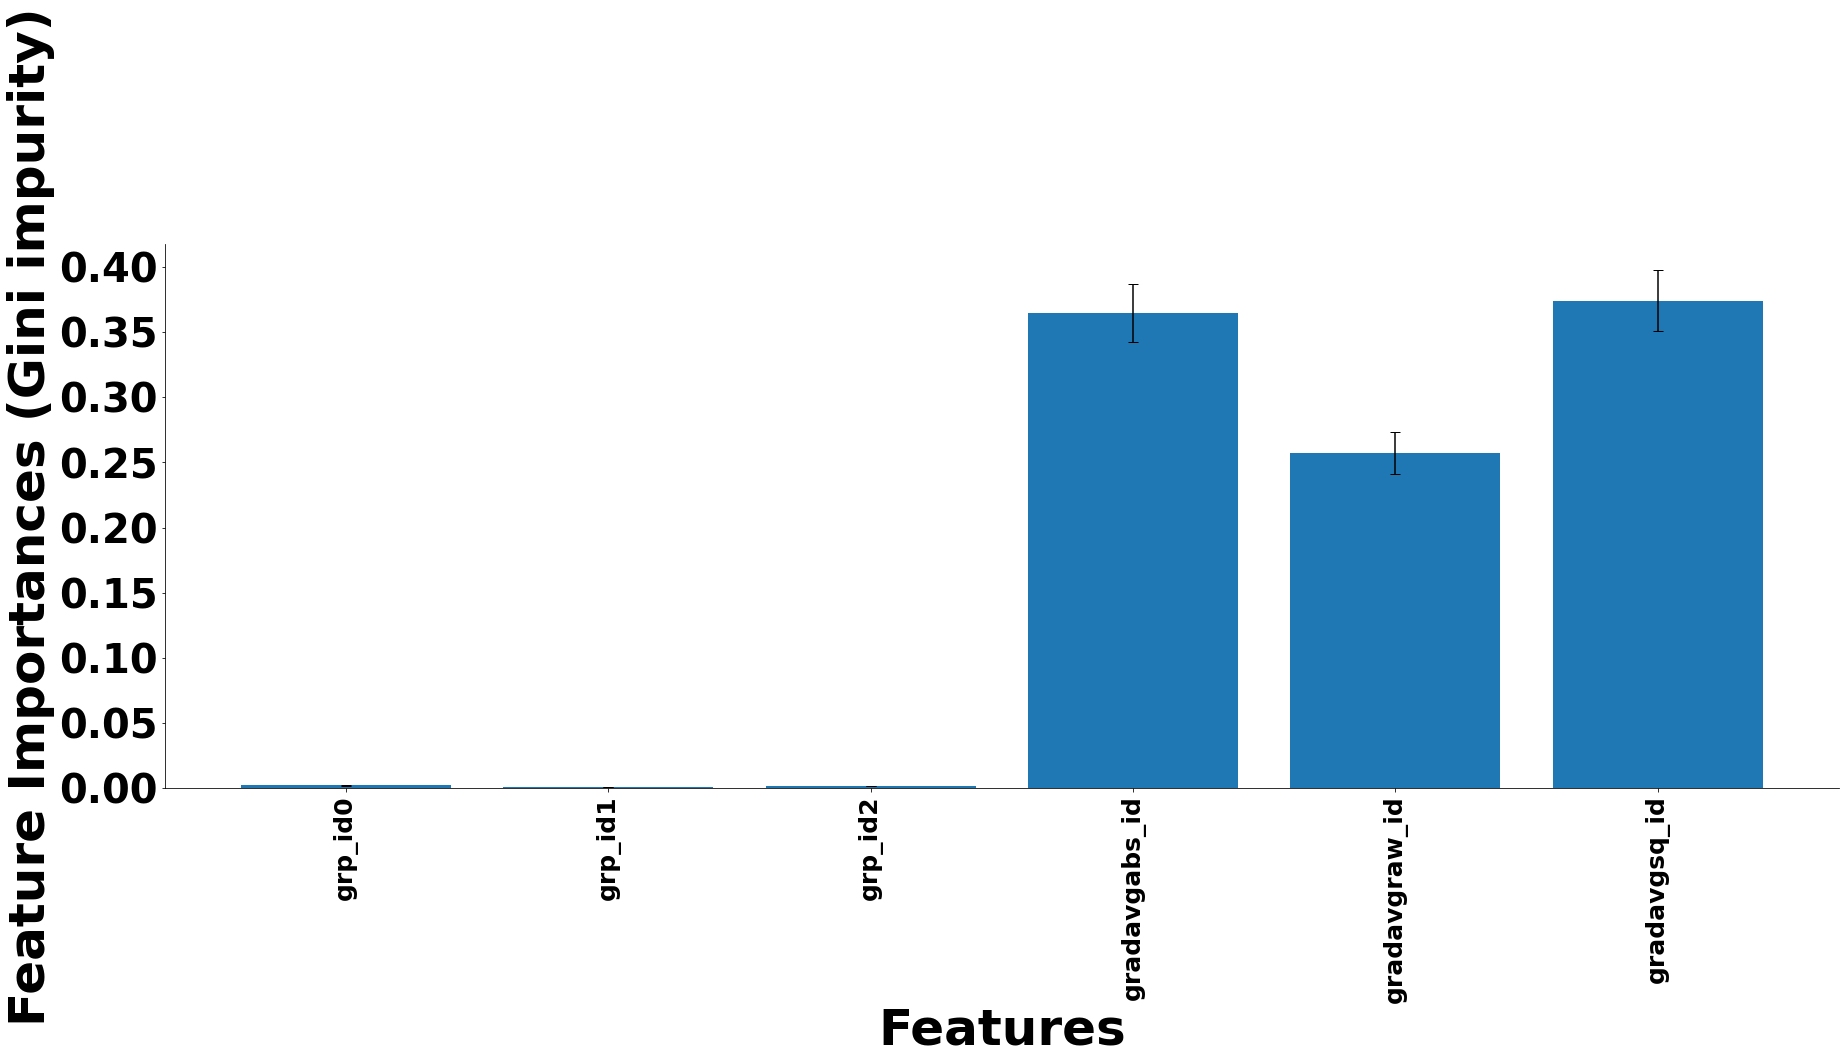

In [20]:
# averaged layer-wise activity changes plot

from scipy.stats import sem

fig = plt.figure(figsize=(30, 10))

trajectory_len = data['X'].shape[1]
observable_trajectory_names = list(cls_out.results['feature_names'])
# observable_trajectory_names = list(cls_out.results['feature_names'][:3]) \
#                              + list(np.repeat(cls_out.results['feature_names'][3:], trajectory_len))
x = np.arange(len(observable_trajectory_names))
feat_importances = np.row_stack(cls_out.results['feature_importances_by_split'])

feat_importances_gridMean = np.mean(feat_importances, axis=0)
feat_importances_gridMean_3 = feat_importances_gridMean[:3]
feat_importances_gridMean_real = feat_importances_gridMean[3:]
gridMean_split = np.split(feat_importances_gridMean_real,3)
feat_importances_gridMean_sum = np.zeros(6,)
feat_importances_gridMean_sum[:3] = feat_importances_gridMean_3
feat_importances_gridMean_sum[3:] = np.sum(gridMean_split,axis=1)

feat_importances_gridsem = sem(feat_importances, axis=0)
feat_importances_gridsem_3 = feat_importances_gridsem[:3]
feat_importances_gridsem_real = feat_importances_gridsem[3:]
gridsem_split = np.split(feat_importances_gridsem_real,3)
feat_importances_gridsem_sum = np.zeros(6,)
feat_importances_gridsem_sum[:3] = feat_importances_gridsem_3
feat_importances_gridsem_sum[3:] = np.sum(gridsem_split,axis=1)

plt.bar(x, 
        feat_importances_gridMean_sum,
        yerr = feat_importances_gridsem_sum,
        capsize=5)
plt.xticks(x, observable_trajectory_names, rotation=90, 
           fontsize=25, fontweight='bold')
plt.yticks(fontsize=40, fontweight='bold')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Features', fontsize=50, fontweight='bold')
plt.ylabel('Feature Importances (Gini impurity)', fontsize=50, fontweight='bold')
plt.show()
